In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!pip install -U scikit-learn
!pip install progress

     |████████████████████████████████| 22.3 MB 1.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
  Using cached progress-1.5.tar.gz (5.8 kB)
  Created wheel for progress: filename=progress-1.5-py3-none-any.whl size=8074 sha256=0210768837edc6ba3a552c9d5ccdbbec09810cf5f0c04d1838bc7e10bdadd323
  Stored in directory: /root/.cache/pip/wheels/4c/ff/85/0cabf2cb317421028ef98853ae5c8d84c31f3e4e11862ea977
Successfully built progress


https://medium.com/dropout-analytics/installing-rapids-ai-in-google-colab-87c247f2c468


In [ ]:
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)

if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
  raise Exception("""
                     Unfortunately this instance does not have a T4, P4 or P100 GPU.\n
                     Please make sure you've configured Colab to request a GPU instance type.\n
                     Sometimes Colab allocates a Tesla K80 instead of a T4, P4 or P100. Resetting the instance.If you get a K80 GPU, try Runtime -> Reset all runtimes...""")
else:
  print('Woo! You got the right kind of GPU!')

Woo! You got the right kind of GPU!


In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

In [ ]:
import cugraph
import cudf
import networkx as nx
import numpy as np

def modularity_spectral_clustering(graph, num_clusters):
  edge_list = nx.to_pandas_edgelist(graph)
  edge_list.columns = ['source', 'destination'] 
  edge_list['edge_attr'] = np.ones(graph.number_of_edges(), dtype=float)
  graph_gpu = cugraph.Graph()
  graph_gpu.from_pandas_edgelist(edge_list, source='source', destination='destination',
                         edge_attr='edge_attr', renumber=False)
  graph_gpu = graph_gpu.to_undirected()
  comms = cugraph.spectralModularityMaximizationClustering(graph_gpu, num_clusters)
  return  comms['cluster'].to_array()


## Hedonic games approach

In [ ]:
import scipy as sp
import scipy.stats
import numpy as np
import networkx as nx

def get_comms(g):
    return [node["comm"] for _, node in g.nodes.items()]

def label_graph(g, n_comms):
    for index, node in g.nodes.items():
        node["comm"] = 0
    comms = get_comms(g)
    g.graph["ns"] = np.bincount(comms, minlength=n_comms)

def get_probs(beta_freqs):
    bf = beta_freqs - np.max(beta_freqs)
    pr = np.exp(bf)
    pr /= np.sum(pr)
    return pr

def make_step(g, alpha, beta, gamma, index):
    n_comms = len(g.graph["ns"])
    comms = [g.nodes[i]["comm"] for i in g.neighbors(index)]
    ns = g.graph["ns"]
    ns[g.nodes[index]["comm"]] -= 1
    freqs = np.bincount(comms, minlength = n_comms) - alpha * ns
    freqs[ns == 0] -= gamma
    probs = get_probs(beta * freqs)
    new_comm = sp.stats.rv_discrete(values = (range(n_comms), probs)).rvs()
    g.nodes[index]["comm"] = new_comm
    ns[new_comm] += 1

def random_step(g, alpha, beta, gamma):
    index = np.random.randint(g.order())
    make_step(g, alpha, beta, gamma, index)
        
def run_algo(g, alpha, beta, gamma, iters=20):
    evolution = [get_comms(g)]
    for _ in range(iters):
        for _ in g.nodes():
            random_step(g, alpha, beta, gamma)
        evolution.append(get_comms(g))
    return evolution

def extract_comms(evolution, iters=10):
    comms = []
    for ev in zip(*evolution):
        comm = np.argmax(np.bincount(ev[-iters:]))
        comms.append(comm)
    return comms

def run_until_cluster(g, alpha, beta, gamma, n_comms):
    gt = g
    label_graph(gt, n_comms)
    evolution = run_algo(gt, alpha, beta, gamma)
    comms = extract_comms(evolution)
    return comms, evolution

def hedonic_clustering(graph, num_clusters):
    alpha = graph.number_of_edges() / (graph.number_of_nodes() * (graph.number_of_nodes() - 1.0) / 2.0)
    beta = 20
    gamma = 0
    labels, evolution = run_until_cluster(graph, alpha, beta, gamma, num_clusters )
    return np.array(labels)

## Spectral clustering algorithms
- spectral clustering is an approximate of RatioCut
- normalized clustering is an approximate of NCut

In [ ]:
import numpy as np
import networkx as nx
import numpy.linalg as la
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.sparse import csgraph



In [ ]:
def spectral_clustering(graph, num_clusters):
  A = nx.adjacency_matrix(graph)
  D = np.diag(np.ravel(np.sum(A,axis=1)))
  L = D - A
  l, U = la.eigh(L)
  kmeans = KMeans(n_clusters=num_clusters).fit(U[:,1:num_clusters])
  labels_ = kmeans.labels_
  return  labels_

def normalized_spectral_clustering(graph, num_clusters):
  l, U = la.eigh(csgraph.laplacian(nx.adjacency_matrix(graph).todense(), normed=True))
  kmeans = KMeans(n_clusters=num_clusters).fit(U[:,1:num_clusters])
  labels_ = kmeans.labels_
  return labels_

## The asynchronous fluid communities algorithm
The algorithm is based on the simple idea of fluids interacting in an environment, expanding and pushing each other. Its initialization is random, so found communities may vary on different executions.

The algorithm proceeds as follows. First each of the initial k communities is initialized in a random vertex in the graph. Then the algorithm iterates over all vertices in a random order, updating the community of each vertex based on its own community and the communities of its neighbours. This process is performed several times until convergence. At all times, each community has a total density of 1, which is equally distributed among the vertices it contains. If a vertex changes of community, vertex densities of affected communities are adjusted immediately. When a complete iteration over all vertices is done, such that no vertex changes the community it belongs to, the algorithm has converged and returns.

In [ ]:
def async_fluid(graph, num_clusters):
    comms = nx.community.asyn_fluidc(graph,num_clusters)
    labels_ = np.zeros(graph.number_of_nodes(), dtype=int)
    for k, comm in enumerate(comms):
        for label in comm:
            labels_[label] = k
    return  labels_

##  Service to create weighted SBM

In [ ]:
def create_weighted_graph(graph, p_in, p_out, num_groups = 2, distribution = [80, 110] ):
    new_edges =[]
    weighted_graph = nx.Graph()

    for edge in edges:
        src = edge[0]
        dst = edge[1]
        if (src < graph.number_of_nodes()/2 and dst < graph.number_of_nodes()/2) or (src > graph.number_of_nodes()/2 and dst > graph.number_of_nodes()/2):
            #new_edges.append((edge[0], edge[1], p_in * random.uniform(distribution[0], distribution[-1])))
            weighted_graph.add_edge(src,dst, weight=p_in * random.uniform(distribution[0], distribution[-1]))
        else:
            #new_edges.append((edge[0], edge[1], p_out * random.uniform(distribution[0], distribution[-1])))
            weighted_graph.add_edge(src,dst, weight=p_out * random.uniform(distribution[0], distribution[-1]))
    return weighted_graph

## Tools for analyzing graph clustering algorithms

In [ ]:
#import importlib
#importlib.reload(sklearn)

import sklearn
import numpy as np
import networkx as nx
import numpy.linalg as la
import scipy.cluster.vq as vq
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import statistics
import csv
import warnings
warnings.filterwarnings('ignore')

from progress.bar import IncrementalBar
from tqdm import tqdm

from scipy.sparse import csgraph
from sklearn.metrics.cluster import rand_score
#from sklearn.metrics import rand_score
from sklearn.metrics.cluster import adjusted_rand_score

import networkx.algorithms.community as nx_comm


def get_true_labels(num_groups, num_members):
    true_labels = np.zeros(num_groups * num_members, dtype=int)
    for i in range(0, num_groups):
        for j in  range(0, num_members):
            true_labels[i*num_members + j] = i
    return true_labels

def get_partition(labels):
    partition = []
    for i in range(labels.max() + 1):
        partition.append(np.where(labels == i)[0])
    return partition


def analyze_clustering_by_probs(clustering_kind = normalized_spectral_clustering, num_clusters = 3, num_members_in_cluster = 10, p_ins = np.linspace( 0.999999999999, 1, 1 ), p_outs = np.linspace( 0, 0.0000001, 1 ), num_repeats = 100):
    ris = np.zeros(p_ins.shape[0] * p_outs.shape[0])
    aris = np.zeros(p_ins.shape[0] * p_outs.shape[0])
    true_labels = get_true_labels(num_clusters, num_members_in_cluster)
    iter = 0
    for p_in in p_ins:
        for p_out in p_outs:
            ri = np.zeros(num_repeats)
            ari = np.zeros(num_repeats)
            for repeat in range(0, num_repeats):
                labels = clustering_kind(nx.planted_partition_graph(num_clusters, num_members_in_cluster, p_in,  p_out), num_clusters)
                ri[repeat] = rand_score(true_labels, labels)
                ari[repeat] = adjusted_rand_score(true_labels, labels)
            ris[iter] = ri.mean()
            aris[iter] = ari.mean()
        iter += 1
    return aris,  ris

def analyze_clustering(clustering_kind = normalized_spectral_clustering,
                       num_clusters = 3,
                       num_members_in_cluster = 200,
                       p_ins = np.linspace( 0.999999999999, 1, 1 ),
                       degree = 250.,
                       num_repeats = 1000,
                       quality_metrics = ['RI', 'ARI', 'modularity']):
    metrics = {k:None for k in quality_metrics}
    for k in metrics:
        metrics[k] = []#np.zeros(p_ins.shape[0])

    true_labels = get_true_labels(num_clusters, num_members_in_cluster)
    iter = 0
    #bar = IncrementalBar('Countdown', max = p_ins.shape[0])
    for p_in in tqdm(p_ins):
        p_out = (degree - (float(num_members_in_cluster - 1))*p_in) / ((num_clusters - 1) * (num_members_in_cluster - 1))
        if p_out < 0:
            break
        #print(p_out)
        if 'RI'in quality_metrics:
            ri = np.zeros(num_repeats)
        if 'ARI'in quality_metrics:
            ari = np.zeros(num_repeats)
        if 'modularity' in quality_metrics:
            modularity = np.zeros(num_repeats)
            
        for repeat in range(0, num_repeats):
            #generatig graph
            graph = nx.planted_partition_graph(num_clusters, num_members_in_cluster, p_in,  p_out)
            #clustering
            labels = clustering_kind(graph, num_clusters)

            #compute quality metrics
            if 'RI'in quality_metrics:
                ri[repeat] = rand_score(true_labels, labels)
            if 'ARI'in quality_metrics:
                ari[repeat] = adjusted_rand_score(true_labels, labels)
            if 'modularity'in quality_metrics:
                modularity[repeat] = nx_comm.modularity(graph, get_partition(labels))
        
        #save quality metrics mean 
        if 'RI'in quality_metrics:
            metrics['RI'].append(ri.mean())
        if 'ARI'in quality_metrics:
            metrics['ARI'].append(ari.mean())
        if 'modularity'in quality_metrics:
            metrics['modularity'].append(modularity.mean())
        
        iter += 1
        #bar.next()

    #bar.finish()
    return metrics



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_quality(p_ins, metric, name ):
    plt.plot(p_ins[:len(metric)], metric)
    plt.xlabel('P_in', size=14)
    plt.ylabel(name, size=14)
    plt.title(name + ' accuracy of clustering', size=16)
    return

def plot_quality_comparison(p_ins, results, name ):
    fig, ax = plt.subplots()
    colors = ['-b', '-r', '-g', '-y', '-p']
    for k, clustering in enumerate(results):   
        ax.plot(p_ins, results[clustering], colors[k], label=clustering)
    #ax.axis('equal')#ax.axis('p_in')
    leg = ax.legend();
    #plt.plot(p_ins[:len(metric)], metric)
    #plt.xlabel('P_in', size=14)
    #plt.ylabel(name, size=14)
    plt.title(name, size=16)
    return


def save_res_to_csv(res, p_ins, name = 'result.csv'):
    df = pd.DataFrame(data=np.array(list((res.values()))).T, columns=list(res.keys()))
    df['p_in'] = p_ins[:len(list(res.values())[0])] 
    df.to_csv(name, index = False, header=True)
    return


def get_result(file_name):
    df = pd.read_csv(file_name)
    return df

In [ ]:
%ls | grep clustering

clustering_degree_150
clustering_degree_50
hedonic_clustering_cluster_size_100_degree_75_num_clusters_3
hedonic_clustering_cluster_size_200_degree_150_num_clusters_3
hedonic_clustering_cluster_size_50_degree_35_num_clusters_5
hedonic_clustering_degree_150
normalized_clustering_degree_150
normalized_clustering_degree_150 num_clusters 6
normalized_clustering_degree_50
normalized_spectral_clustering_cluster_size_100_degree_75_num_clusters_3
normalized_spectral_clustering_cluster_size_200_degree_150_num_clusters_3
normalized_spectral_clustering_cluster_size_50_degree_35_num_clusters_5
regularized_spectral_clustering_page239.pdf
spectral_clustering_cluster_size_100_degree_75_num_clusters_3
spectral_clustering_cluster_size_200_degree_150_num_clusters_3
spectral_clustering_cluster_size_50_degree_35_num_clusters_5


In [ ]:
def plot_algorithms_comparison(algos = [spectral_clustering, normalized_spectral_clustering, hedonic_clustering, async_fluid, modularity_spectral_clustering], num_clusters = 3, cluster_size = 100, degree = 75):
    algo_names = [algo.__name__ for algo in algos]
    output_files =[algo_name + '_cluster_size_' + str(cluster_size) + '_degree_' + str(degree) + '_num_clusters_' + str(num_clusters) for algo_name in algo_names]
    algos_res = [get_result(output_file) for output_file in output_files]
    metrics = list(algos_res[0].columns[:-1])
    p_ins = algos_res[0]['p_in'].to_numpy()
    for metric in metrics:
        plot_quality_comparison(p_ins, {algo_name : algos_res[k][metric].to_numpy() for k, algo_name in enumerate(algo_names)}, name = metric + '_cluster_size_' + str(cluster_size) + '_degree_' + str(degree) + '_num_clusters_' + str(num_clusters))

In [ ]:
def compare_algorithms(algos = [spectral_clustering, normalized_spectral_clustering, hedonic_clustering, async_fluid], num_clusters = 3, cluster_size = 100, degree = 75, p_ins = np.linspace( 0.05, 0.7, 100), num_repeats = [20,20,20] ):
    algo_names = [algo.__name__ for algo in algos]
    output_files =[algo_name + '_cluster_size_' + str(cluster_size) + '_degree_' + str(degree) + '_num_clusters_' + str(num_clusters) for algo_name in algo_names]

    for k, algo in enumerate(algos):
        print(algo_names[k] + " started")
        res = analyze_clustering(clustering_kind = algo, p_ins = p_ins, num_repeats = num_repeats[k], num_clusters=num_clusters, num_members_in_cluster=cluster_size, degree = degree)
        save_res_to_csv(res, p_ins, name = output_files[k])
        print(algo_names[k] + " done")

    algos_res = [get_result(output_file) for output_file in output_files]
    metrics = list(algos_res[0].columns[:-1])
    p_ins = algos_res[0]['p_in'].to_numpy()
    for metric in metrics:
        plot_quality_comparison(p_ins, {algo_name : algos_res[k][metric].to_numpy() for k, algo_name in enumerate(algo_names)}, name = metric + '_cluster_size_' + str(cluster_size) + '_degree_' + str(degree) + '_num_clusters_' + str(num_clusters))


  0%|          | 0/100 [00:00<?, ?it/s]

modularity_spectral_clustering started


100%|██████████| 100/100 [03:38<00:00,  2.18s/it]


modularity_spectral_clustering done


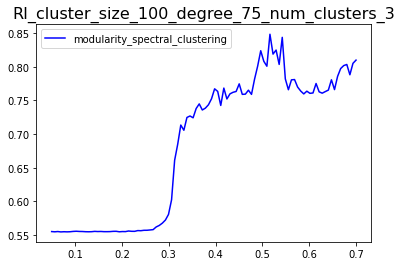

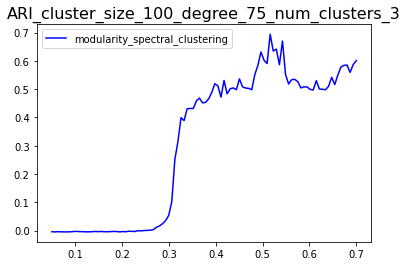

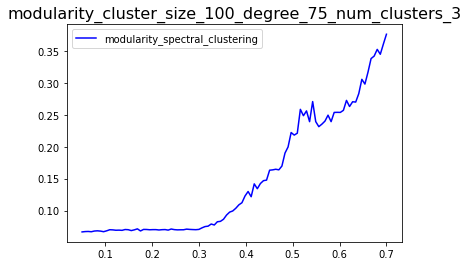

In [ ]:
compare_algorithms(algos = [modularity_spectral_clustering], num_clusters=3, cluster_size= 100, degree = 75,p_ins = np.linspace( 0.05, 0.7, 100), num_repeats = [20])

  0%|          | 0/100 [00:00<?, ?it/s]

modularity_spectral_clustering started


100%|██████████| 100/100 [27:26<00:00, 16.47s/it]


modularity_spectral_clustering done


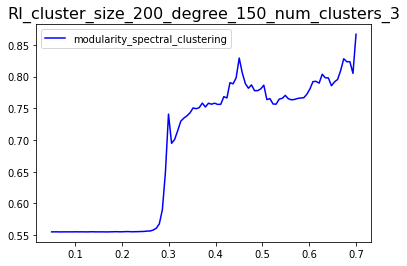

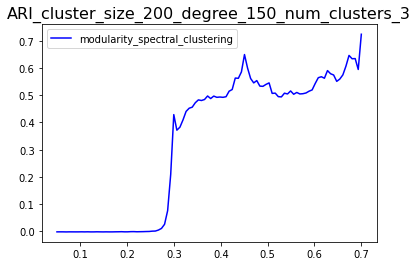

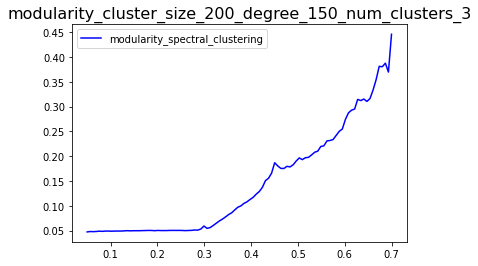

In [ ]:
compare_algorithms(algos = [modularity_spectral_clustering], num_clusters=3, cluster_size= 200, degree = 150,p_ins = np.linspace( 0.05, 0.7, 100), num_repeats = [50])

  0%|          | 0/100 [00:00<?, ?it/s]

modularity_spectral_clustering started


100%|██████████| 100/100 [08:38<00:00,  5.18s/it]


modularity_spectral_clustering done


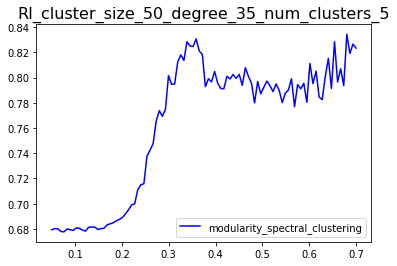

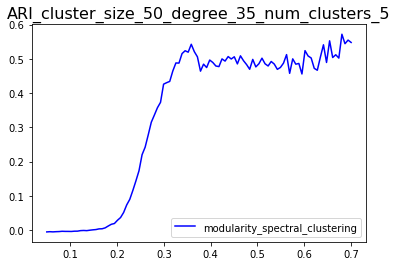

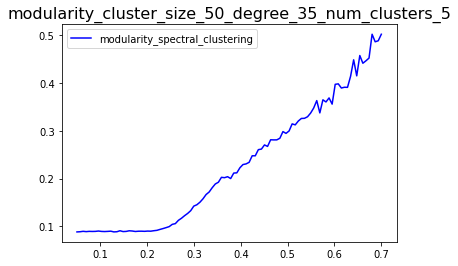

In [ ]:
compare_algorithms(algos = [modularity_spectral_clustering], num_clusters=5, cluster_size= 50, degree = 35,p_ins = np.linspace( 0.05, 0.7, 100), num_repeats = [80])

In [ ]:
compare_algorithms(algos = [modularity_spectral_clustering], num_clusters=10, cluster_size= 500, degree = 500,p_ins = np.linspace( 0.05, 0.7, 100), num_repeats = [50])

  0%|          | 0/100 [00:00<?, ?it/s]

modularity_spectral_clustering started


  3%|▎         | 3/100 [25:12<13:36:50, 505.26s/it]

In [ ]:
compare_algorithms(algos = [modularity_spectral_clustering], num_clusters=3, cluster_size= 1000, degree = 500,p_ins = np.linspace( 0.05, 0.7, 100), num_repeats = [50])

In [ ]:
compare_algorithms(algos = [modularity_spectral_clustering], num_clusters=5, cluster_size= 100, degree = 75,p_ins = np.linspace( 0.05, 0.7, 100), num_repeats = [6])

  0%|          | 0/100 [00:00<?, ?it/s]

async_fluid started


100%|██████████| 100/100 [03:01<00:00,  1.81s/it]


async_fluid done


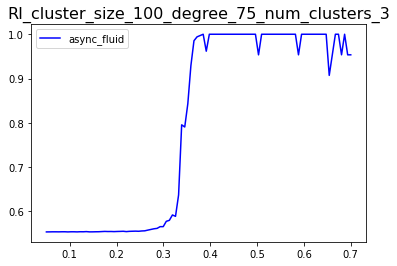

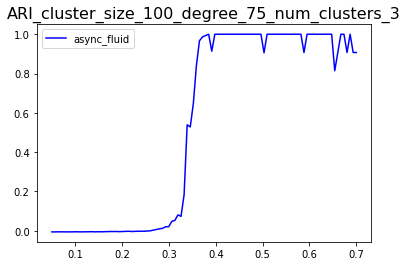

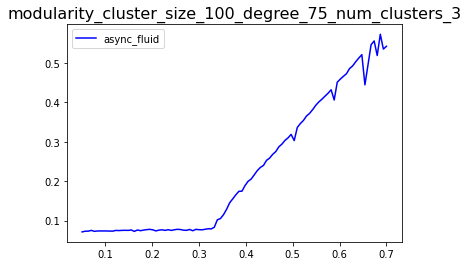

In [ ]:
compare_algorithms(algos = [async_fluid], num_clusters=3, cluster_size= 100, degree = 75,p_ins = np.linspace( 0.05, 0.7, 100), num_repeats = [6])

есть ли масшабирование??? разреженность та же, чсило вершин разное.

  0%|          | 0/100 [00:00<?, ?it/s]

hedonic_clustering started


100%|██████████| 100/100 [55:43<00:00, 33.43s/it]


hedonic_clustering done


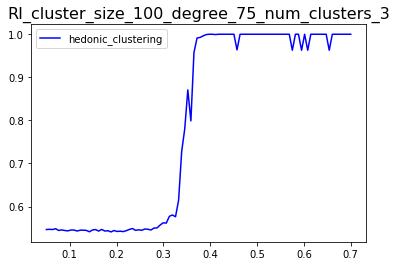

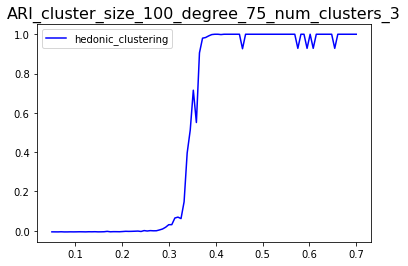

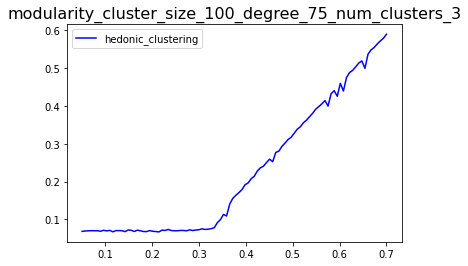

In [ ]:
compare_algorithms(algos = [hedonic_clustering], num_clusters=3, cluster_size= 100, degree = 75,p_ins = np.linspace( 0.05, 0.7, 100), num_repeats = [6])

  0%|          | 0/100 [00:00<?, ?it/s]

spectral_clustering started


  0%|          | 0/100 [00:00<?, ?it/s]

spectral_clustering done
normalized_spectral_clustering started


100%|██████████| 100/100 [06:35<00:00,  3.95s/it]


normalized_spectral_clustering done


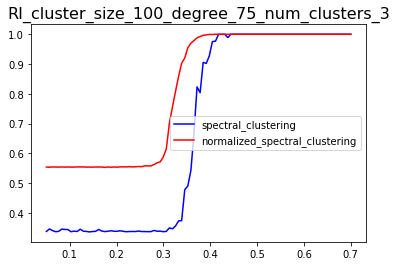

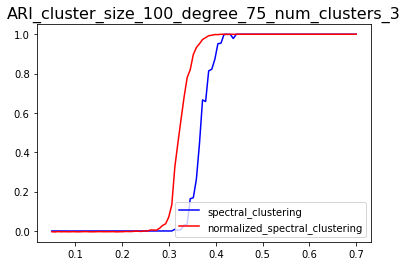

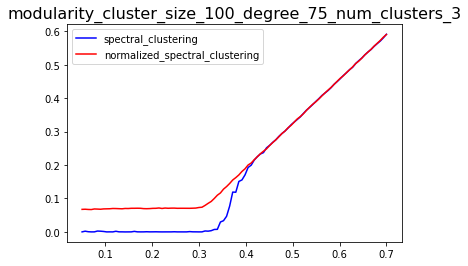

In [ ]:
compare_algorithms(algos = [spectral_clustering, normalized_spectral_clustering], num_clusters=3, cluster_size= 100, degree = 75,p_ins = np.linspace( 0.05, 0.7, 100), num_repeats = [20,20])

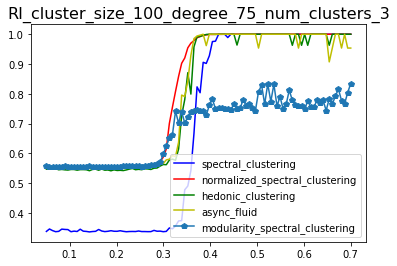

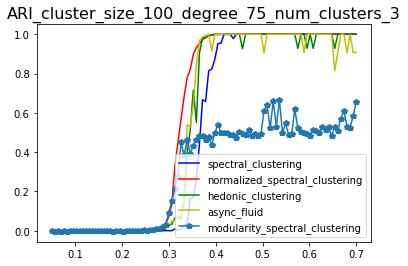

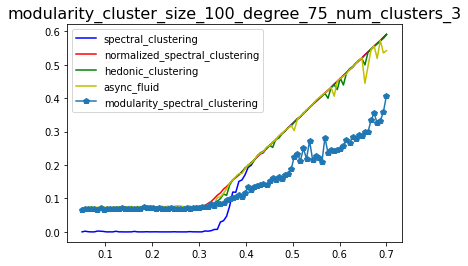

In [ ]:
plot_algorithms_comparison(num_clusters=3, cluster_size= 100, degree = 75)

In [ ]:
check theory bound of phase transition.

  0%|          | 0/100 [00:00<?, ?it/s]

spectral_clustering started


  0%|          | 0/100 [00:00<?, ?it/s]

spectral_clustering done
normalized_spectral_clustering started


100%|██████████| 100/100 [03:50<00:00,  2.30s/it]


normalized_spectral_clustering done


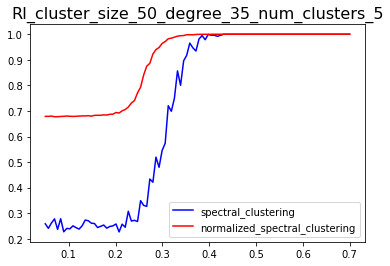

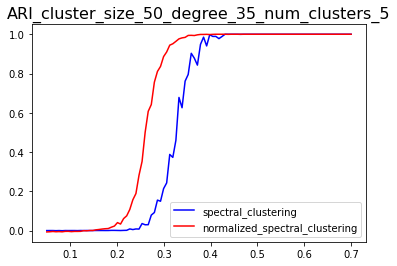

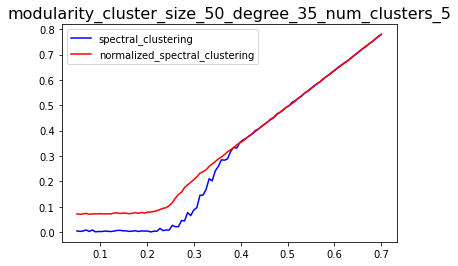

In [ ]:
compare_algorithms(algos = [spectral_clustering, normalized_spectral_clustering], num_clusters=5, cluster_size= 50, degree = 35,p_ins = np.linspace( 0.05, 0.7, 100), num_repeats = [20,20])

In [ ]:
compare_algorithms(algos = [spectral_clustering, normalized_spectral_clustering], num_clusters=5, cluster_size= 50, degree = 35,p_ins = np.linspace( 0.05, 0.7, 100), num_repeats = [20,20])

spectral_clustering started


UnsupportedError: ignored

In [ ]:
algos_res = [get_result(output_file) for output_file in output_files]
len(algos_res)

3

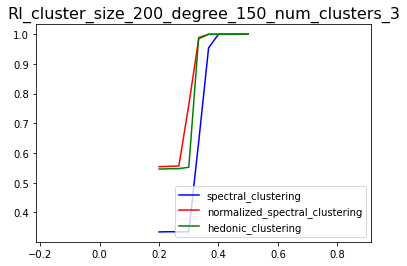

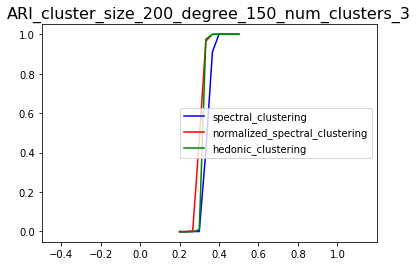

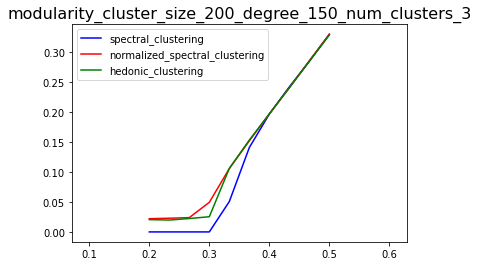

In [ ]:
algos_res = [get_result(output_file) for output_file in output_files]
metrics = list(algos_res[0].columns[:-1])
p_ins = algos_res[0]['p_in'].to_numpy()
for metric in metrics:
    plot_quality_comparison(p_ins, {algo_name : algos_res[k][metric].to_numpy() for k, algo_name in enumerate(algo_names)}, name = metric + '_cluster_size_' + str(cluster_size) + '_degree_' + str(degree) + '_num_clusters_' + str(num_clusters))

In [ ]:
h_res = get_result('hedonic_clustering_degree_150')
nsc_res = get_result('normalized_clustering_degree_150')
sc_res = get_result('clustering_degree_150')

In [ ]:
list(sc_res.columns[:-1])

['RI', 'ARI', 'modularity']

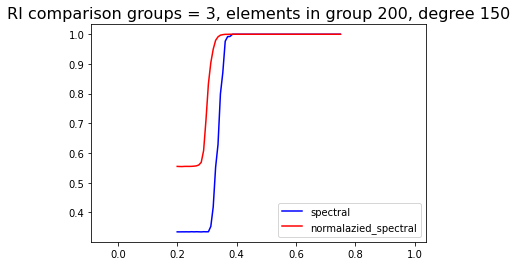

In [ ]:
metrics = ['RI']
algo_names = ['spectral', 'normalazied_spectral']
algo_res = [sc_res, nsc_res]
for metric in metrics:
    plot_quality_comparison(sc_res['p_in'].to_numpy(), {algorithm:algo_res[k][metric].to_numpy() for k, algorithm in enumerate(algo_names)}, name = metric + " comparison groups = 3, elements in group 200, degree 150")

 68%|██████▊   | 17/25 [35:37<16:44, 125.59s/it]

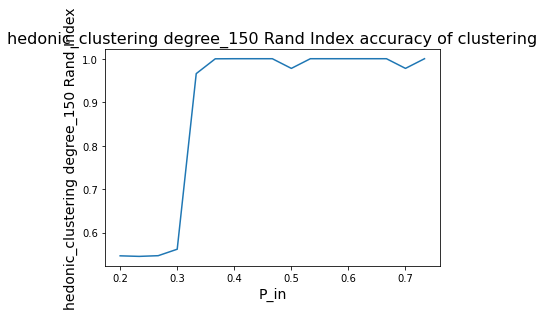

In [ ]:
p_ins = np.linspace( 0.2, 1, 25)
res2 = analyze_clustering(clustering_kind= hedonic_clustering, p_ins = p_ins, num_repeats = 10, degree = 150)
save_res_to_csv(res2, p_ins, name = 'hedonic_clustering_degree_150')
plot_quality(p_ins, res2['RI'], 'hedonic_clustering degree_150 Rand Index')



  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [02:02<48:48, 122.00s/it]

  8%|▊         | 2/25 [04:05<46:54, 122.38s/it]

 12%|█▏        | 3/25 [06:09<45:03, 122.88s/it]

 16%|█▌        | 4/25 [08:13<43:05, 123.14s/it]

 20%|██        | 5/25 [10:15<41:01, 123.08s/it]

 24%|██▍       | 6/25 [12:19<38:58, 123.08s/it]

 28%|██▊       | 7/25 [14:22<36:55, 123.09s/it]

 32%|███▏      | 8/25 [16:26<34:58, 123.44s/it]

 36%|███▌      | 9/25 [18:29<32:51, 123.23s/it]

 40%|████      | 10/25 [20:32<30:46, 123.12s/it]

 44%|████▍     | 11/25 [22:36<28:47, 123.42s/it]

 48%|████▊     | 12/25 [24:40<26:49, 123.81s/it]

 52%|█████▏    | 13/25 [26:45<24:48, 124.05s/it]

 56%|█████▌    | 14/25 [28:48<22:41, 123.80s/it]

 60%|██████    | 15/25 [30:52<20:38, 123.81s/it]

 64%|██████▍   | 16/25 [32:56<18:35, 123.99s/it]

 68%|██████▊   | 17/25 [34:58<16:26, 123.28s/it]

 72%|███████▏  | 18/25 [37:02<14:23, 123.39s/it]

 76%|███████▌  | 19/25 [39:05<12:19, 123.22s/it]

 80%|████████  | 

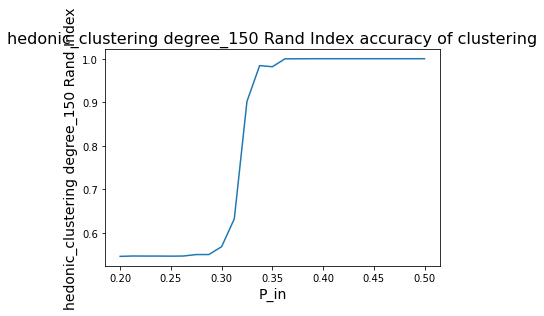

In [ ]:
p_ins = np.linspace( 0.2, 0.5, 25)
res2 = analyze_clustering(clustering_kind= hedonic_clustering, p_ins = p_ins, num_repeats = 10, degree = 150)
save_res_to_csv(res2, p_ins, name = 'hedonic_clustering_degree_150')
plot_quality(p_ins, res2['RI'], 'hedonic_clustering degree_150 Rand Index')

In [ ]:
p_ins = np.linspace( 0.2, 1, 100 )
res2 = analyze_clustering(clustering_kind= normalized_spectral_clustering, p_ins = p_ins, num_repeats = 30, degree = 150)
save_res_to_csv(res2, p_ins, name = 'normalized_clustering_degree_150')
plot_quality(p_ins, res2['RI'], 'normalized_clustering degree_150 Rand Index')


In [ ]:
p_ins = np.linspace( 0.01, 0.7, 100 )
res2 = analyze_clustering(clustering_kind= normalized_spectral_clustering, p_ins = p_ins, num_repeats = 30, degree = 50)
save_res_to_csv(res2, p_ins, name = 'normalized_clustering_degree_50')
plot_quality(p_ins, res2['RI'], 'normalized_clustering degree_50 Rand Index')




  0%|          | 0/100 [00:00<?, ?it/s]


  1%|          | 1/100 [00:16<26:32, 16.08s/it]


  2%|▏         | 2/100 [00:32<26:19, 16.12s/it]


  3%|▎         | 3/100 [00:48<25:57, 16.06s/it]


  4%|▍         | 4/100 [01:04<25:44, 16.09s/it]


  5%|▌         | 5/100 [01:20<25:17, 15.98s/it]


  6%|▌         | 6/100 [01:36<25:04, 16.00s/it]


  7%|▋         | 7/100 [01:52<24:45, 15.98s/it]


  8%|▊         | 8/100 [02:08<24:38, 16.07s/it]


  9%|▉         | 9/100 [02:24<24:23, 16.09s/it]


 10%|█         | 10/100 [02:40<24:05, 16.06s/it]


 11%|█         | 11/100 [02:56<23:45, 16.02s/it]


 12%|█▏        | 12/100 [03:12<23:31, 16.04s/it]


 13%|█▎        | 13/100 [03:28<23:24, 16.15s/it]


 14%|█▍        | 14/100 [03:44<23:03, 16.09s/it]


 15%|█▌        | 15/100 [04:00<22:46, 16.07s/it]


 16%|█▌        | 16/100 [04:17<22:32, 16.11s/it]


 17%|█▋        | 17/100 [04:32<22:10, 16.03s/it]


 18%|█▊        | 18/100 [04:49<22:00, 16.11s/it]


 19%|█▉        | 19/100 [05:05<21:46, 16.13s/i

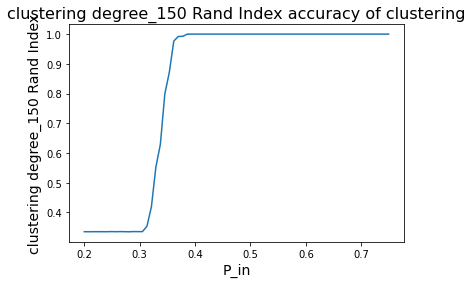

In [ ]:
p_ins = np.linspace( 0.2, 1, 100 )
res2 = analyze_clustering(clustering_kind= spectral_clustering, p_ins = p_ins, num_repeats = 30, degree = 150)
save_res_to_csv(res2, p_ins, name = 'clustering_degree_150')
plot_quality(p_ins, res2['RI'], 'clustering degree_150 Rand Index')





  0%|          | 0/100 [00:00<?, ?it/s]



  1%|          | 1/100 [00:09<15:26,  9.36s/it]



  2%|▏         | 2/100 [00:18<15:15,  9.34s/it]



  3%|▎         | 3/100 [00:27<15:03,  9.32s/it]



  4%|▍         | 4/100 [00:36<14:44,  9.21s/it]



  5%|▌         | 5/100 [00:46<14:42,  9.29s/it]



  6%|▌         | 6/100 [00:56<14:46,  9.43s/it]



  7%|▋         | 7/100 [01:05<14:30,  9.36s/it]



  8%|▊         | 8/100 [01:15<14:34,  9.51s/it]



  9%|▉         | 9/100 [01:24<14:23,  9.49s/it]



 10%|█         | 10/100 [01:33<13:57,  9.31s/it]



 11%|█         | 11/100 [01:42<13:51,  9.34s/it]



 12%|█▏        | 12/100 [01:52<13:46,  9.39s/it]



 13%|█▎        | 13/100 [02:01<13:35,  9.37s/it]



 14%|█▍        | 14/100 [02:11<13:29,  9.41s/it]



 15%|█▌        | 15/100 [02:20<13:09,  9.29s/it]



 16%|█▌        | 16/100 [02:29<13:02,  9.32s/it]



 17%|█▋        | 17/100 [02:38<12:51,  9.30s/it]



 18%|█▊        | 18/100 [02:48<12:50,  9.40s/it]



 19%|█▉        | 19/100 [0

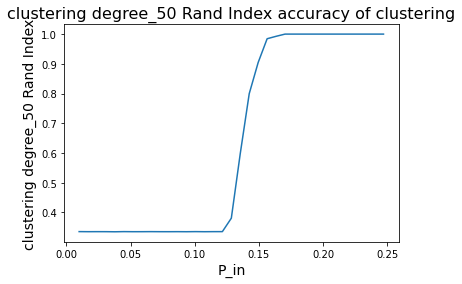

In [ ]:
p_ins = np.linspace( 0.01, 0.7, 100 )
res2 = analyze_clustering(clustering_kind= spectral_clustering, p_ins = p_ins, num_repeats = 30, degree = 50)
save_res_to_csv(res2, p_ins, name = 'clustering_degree_50')
plot_quality(p_ins, res2['RI'], 'clustering degree_50 Rand Index')






  0%|          | 0/100 [00:00<?, ?it/s]




  1%|          | 1/100 [00:31<51:18, 31.10s/it]




  2%|▏         | 2/100 [01:01<50:38, 31.01s/it]




  3%|▎         | 3/100 [01:32<49:56, 30.89s/it]




  4%|▍         | 4/100 [02:03<49:21, 30.85s/it]




  5%|▌         | 5/100 [02:34<48:53, 30.88s/it]




  6%|▌         | 6/100 [03:04<48:14, 30.80s/it]




  7%|▋         | 7/100 [03:35<47:44, 30.81s/it]




  8%|▊         | 8/100 [04:06<47:11, 30.78s/it]




  9%|▉         | 9/100 [04:36<46:35, 30.72s/it]




 10%|█         | 10/100 [05:07<46:07, 30.75s/it]




 11%|█         | 11/100 [05:38<45:40, 30.79s/it]




 12%|█▏        | 12/100 [06:09<45:11, 30.81s/it]




 13%|█▎        | 13/100 [06:40<44:38, 30.78s/it]




 14%|█▍        | 14/100 [07:10<43:59, 30.70s/it]




 15%|█▌        | 15/100 [07:41<43:22, 30.61s/it]




 16%|█▌        | 16/100 [08:11<42:43, 30.52s/it]




 17%|█▋        | 17/100 [08:41<42:05, 30.43s/it]




 18%|█▊        | 18/100 [09:10<40:57, 29.97s/it]




 19%|█

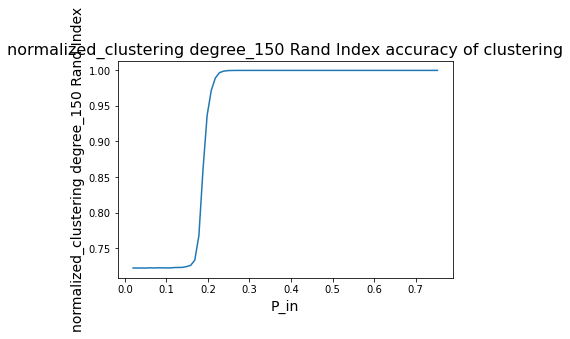

In [ ]:
p_ins = np.linspace( 0.02, 1, 100 )
res2 = analyze_clustering(num_clusters = 6 ,clustering_kind= normalized_spectral_clustering, p_ins = p_ins, num_repeats = 20, degree = 150)
save_res_to_csv(res2, p_ins, name = 'normalized_clustering_degree_150 num_clusters 6')
plot_quality(p_ins, res2['RI'], 'normalized_clustering degree_150 Rand Index')

In [ ]:
p_ins = np.linspace( 0.02, 1, 100 )
res2 = analyze_clustering(num_clusters = 6, num_members_in_cluster = 500, clustering_kind= normalized_spectral_clustering, p_ins = p_ins, num_repeats = 20, degree = 350)
save_res_to_csv(res2, p_ins, name = 'normalized_clustering_degree_350 num_clusters 6')
plot_quality(p_ins, res2['RI'], 'normalized_clustering degree_350 Rand Index')







  0%|          | 0/100 [00:00<?, ?it/s]





  1%|          | 1/100 [04:15<7:01:50, 255.66s/it]





  2%|▏         | 2/100 [08:46<7:04:58, 260.19s/it]





  3%|▎         | 3/100 [13:20<7:07:14, 264.28s/it]





  4%|▍         | 4/100 [18:02<7:11:42, 269.81s/it]





  5%|▌         | 5/100 [22:33<7:07:28, 269.98s/it]





  6%|▌         | 6/100 [26:57<7:00:17, 268.27s/it]





  7%|▋         | 7/100 [31:14<6:50:27, 264.82s/it]





  8%|▊         | 8/100 [35:29<6:41:43, 261.99s/it]





  9%|▉         | 9/100 [39:38<6:31:30, 258.14s/it]





 10%|█         | 10/100 [43:48<6:23:13, 255.48s/it]





 11%|█         | 11/100 [47:54<6:14:47, 252.66s/it]





 12%|█▏        | 12/100 [52:04<6:09:33, 251.97s/it]





 13%|█▎        | 13/100 [56:13<6:04:04, 251.09s/it]





 14%|█▍        | 14/100 [1:00:20<5:58:14, 249.94s/it]





 15%|█▌        | 15/100 [1:04:20<5:49:49, 246.93s/it]





 16%|█▌        | 16/100 [1:08:18<5:41:41, 244.06s/it]





 17%|█▋        | 17/100 [1:12:18<5:36:15

In [ ]:
p_ins = np.linspace( 0.2, 1, 10 )
#aris, ris = analyze_clustering(p_ins = p_ins, p_outs = np.array([0]))

In [ ]:
len(list(res2.values())[0])

7

In [ ]:
res2 = analyze_clustering(clustering_kind= normalized_spectral_clustering, p_ins = p_ins, num_repeats = 15, degree = 150)

 70%|███████   | 7/10 [00:57<00:24,  8.10s/it]

In [ ]:
np.array(list((res2.values()))).T

array([[ 0.55475719, -0.00161236,  0.02047256],
       [ 0.60058245,  0.10127319,  0.02746151],
       [ 1.        ,  1.        ,  0.16570587],
       [ 1.        ,  1.        ,  0.28498825],
       [ 1.        ,  1.        ,  0.4030865 ],
       [ 1.        ,  1.        ,  0.52039029],
       [ 1.        ,  1.        ,  0.63964392]])

In [ ]:
save_res_to_csv(res2, p_ins,'result2.csv' )

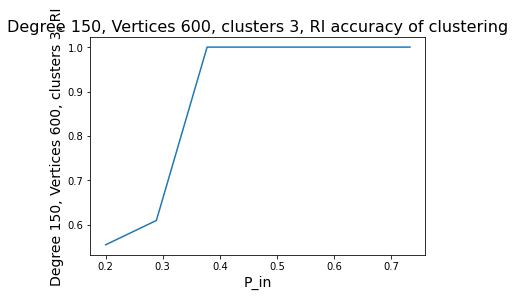

In [ ]:
plot_quality(p_ins, res2['RI'], 'Degree 150, Vertices 600, clusters 3, RI')

In [ ]:
res = analyze_clustering(clustering_kind= normalized_spectral_clustering, p_ins = p_ins, num_repeats = 15, degree = 150)

 40%|████      | 2/5 [00:14<00:21,  7.23s/it]

In [ ]:
res['RI']

[1.0, 1.0]

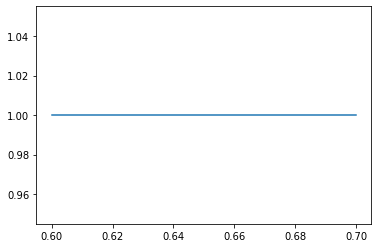

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(p_ins[:len(res['RI'])], res['RI'] )

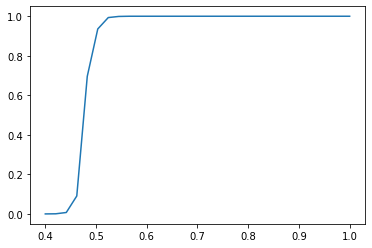

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(p_ins[:len(res['ARI'])], res['ARI'] )

In [ ]:
res['ARI']

array([-7.25709431e-04, -1.04011969e-04,  6.48482541e-03,  9.00243792e-02,
        6.95837130e-01,  9.35628211e-01,  9.93337823e-01,  9.98999163e-01,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00])

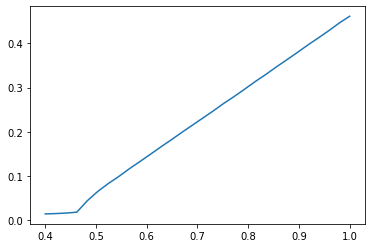

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(p_ins[:len(res['modularity'])], res['modularity'] )

In [ ]:
res['modularity']

array([0.01356393, 0.01435053, 0.0155144 , 0.017475  , 0.04337072,
       0.06447753, 0.08239472, 0.09834169, 0.11578735, 0.13199593,
       0.14849096, 0.16524593, 0.18148462, 0.19817137, 0.214443  ,
       0.23067741, 0.2468904 , 0.26402677, 0.27975397, 0.29641266,
       0.31353843, 0.32946874, 0.34650421, 0.36269245, 0.37922386,
       0.39614989, 0.41219393, 0.42866855, 0.44616967, 0.46160366])

fix degree. 

set relation p_in/p_out?


In [ ]:
g= nx.planted_partition_graph(3, 10, 1, 0.0)
labels = normalized_spectral_clustering(g, num_clusters = 3, num_members_in_cluster= 10)

In [ ]:
labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

## Test for ideal case - to restore communities with RI=1.

In [ ]:
k = 0
while k < 1000:
    g = nx.planted_partition_graph(3, 10, 1, 0.0)
    labels = normalized_spectral_clustering(g, num_clusters = 3, num_members_in_cluster= 10)
    if rand_score(get_true_labels(3,10), labels) < 1:
        print(rand_score(get_true_labels(3,10), labels))
    k +=1  

In [ ]:
get_partition(labels)

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])]

In [ ]:
nx_comm.modularity(g, get_partition(labels))

0.6666666666666666

In [ ]:
rand_score(get_true_labels(3,10), labels)

1.0

In [ ]:
adjusted_rand_score(get_true_labels(3,10), labels)

1.0

In [ ]:
g = nx.planted_partition_graph(3, 10, 0.7, 0.3)
labels = normalized_spectral_clustering(g, num_clusters = 3, num_members_in_cluster= 10)
rand_score(get_true_labels(3,10), labels)

0.9563218390804598